In [1]:
# perceptron

import numpy as np

def sigmoid(x):
    return 1/(1+np.e**(-x))

print(sigmoid(3), sigmoid(-1), sigmoid(-1))
print(sigmoid(1), sigmoid(1), sigmoid(1))
print(sigmoid(1), sigmoid(1), sigmoid(1))
print(sigmoid(-1), sigmoid(3), sigmoid(0))

0.9525741268224331 0.2689414213699951 0.2689414213699951
0.7310585786300049 0.7310585786300049 0.7310585786300049
0.7310585786300049 0.7310585786300049 0.7310585786300049
0.2689414213699951 0.9525741268224331 0.5


In [2]:
import numpy as np

w11 = np.array([-2, -2])
w12 = np.array([2, 2])
w2 = np.array([1, 1])
b1 = 3
b2 = -1
b3 = -1

def perceptron(x, w, b):
    y = np.sum(w*x) + b
    if y <= 0:
        return 0
    else:
        return 1

def NAND(x1, x2):
    return perceptron(np.array([x1, x2]), w11, b1)

def OR(x1, x2):
    return perceptron(np.array([x1, x2]), w12, b2)

def AND(x1, x2):
    return perceptron(np.array([x1, x2]), w2, b3)

def XOR(x1, x2):
    return AND(NAND(x1, x2), OR(x1, x2))

if __name__ == '__main__':
    for x in [(0,0), (0,1), (1,0), (1,1)]:
        y = XOR(x[0], x[1])
        print("input: " + str(x) + " output: " + str(y))

input: (0, 0) output: 0
input: (0, 1) output: 1
input: (1, 0) output: 1
input: (1, 1) output: 0


# 책에서 제공한 code

In [3]:
# Back-Propagation Neural Networks
# 
# Written in Python.  See http://www.python.org/
# Placed in the public domain.
# Neil Schemenauer <nas@arctrix.com>

import math
import random
import string

random.seed(0)

# calculate a random number where:  a <= rand < b
def rand(a, b):
    return (b-a)*random.random() + a

# Make a matrix (we could use NumPy to speed this up)
def makeMatrix(I, J, fill=0.0):
    m = []
    for i in range(I):
        m.append([fill]*J)
    return m

# our sigmoid function, tanh is a little nicer than the standard 1/(1+e^-x)
def sigmoid(x):
    return math.tanh(x)

# derivative of our sigmoid function, in terms of the output (i.e. y)
def dsigmoid(y):
    return 1.0 - y**2

class NN:
    def __init__(self, ni, nh, no):
        # number of input, hidden, and output nodes
        self.ni = ni + 1 # +1 for bias node
        self.nh = nh
        self.no = no

        # activations for nodes
        self.ai = [1.0]*self.ni
        self.ah = [1.0]*self.nh
        self.ao = [1.0]*self.no
        
        # create weights
        self.wi = makeMatrix(self.ni, self.nh)
        self.wo = makeMatrix(self.nh, self.no)
        # set them to random vaules
        for i in range(self.ni):
            for j in range(self.nh):
                self.wi[i][j] = rand(-0.2, 0.2)
        for j in range(self.nh):
            for k in range(self.no):
                self.wo[j][k] = rand(-2.0, 2.0)

        # last change in weights for momentum   
        self.ci = makeMatrix(self.ni, self.nh)
        self.co = makeMatrix(self.nh, self.no)

    def update(self, inputs):
        if len(inputs) != self.ni-1:
            raise ValueError('wrong number of inputs')

        # input activations
        for i in range(self.ni-1):
            #self.ai[i] = sigmoid(inputs[i])
            self.ai[i] = inputs[i]

        # hidden activations
        for j in range(self.nh):
            sum = 0.0
            for i in range(self.ni):
                sum = sum + self.ai[i] * self.wi[i][j]
            self.ah[j] = sigmoid(sum)

        # output activations
        for k in range(self.no):
            sum = 0.0
            for j in range(self.nh):
                sum = sum + self.ah[j] * self.wo[j][k]
            self.ao[k] = sigmoid(sum)

        return self.ao[:]


    def backPropagate(self, targets, N, M):
        if len(targets) != self.no:
            raise ValueError('wrong number of target values')

        # calculate error terms for output
        output_deltas = [0.0] * self.no
        for k in range(self.no):
            error = targets[k]-self.ao[k]
            output_deltas[k] = dsigmoid(self.ao[k]) * error

        # calculate error terms for hidden
        hidden_deltas = [0.0] * self.nh
        for j in range(self.nh):
            error = 0.0
            for k in range(self.no):
                error = error + output_deltas[k]*self.wo[j][k]
            hidden_deltas[j] = dsigmoid(self.ah[j]) * error

        # update output weights
        for j in range(self.nh):
            for k in range(self.no):
                change = output_deltas[k]*self.ah[j]
                self.wo[j][k] = self.wo[j][k] + N*change + M*self.co[j][k]
                self.co[j][k] = change
                #print N*change, M*self.co[j][k]

        # update input weights
        for i in range(self.ni):
            for j in range(self.nh):
                change = hidden_deltas[j]*self.ai[i]
                self.wi[i][j] = self.wi[i][j] + N*change + M*self.ci[i][j]
                self.ci[i][j] = change

        # calculate error
        error = 0.0
        for k in range(len(targets)):
            error = error + 0.5*(targets[k]-self.ao[k])**2
        return error


    def test(self, patterns):
        for p in patterns:
            print(p[0], '->', self.update(p[0]))

    def weights(self):
        print('Input weights:')
        for i in range(self.ni):
            print(self.wi[i])
        print()
        print('Output weights:')
        for j in range(self.nh):
            print(self.wo[j])

    def train(self, patterns, iterations=1000, N=0.5, M=0.1):
        # N: learning rate
        # M: momentum factor
        for i in range(iterations):
            error = 0.0
            for p in patterns:
                inputs = p[0]
                targets = p[1]
                self.update(inputs)
                error = error + self.backPropagate(targets, N, M)
            if i % 100 == 0:
                print('error %-.5f' % error)


def demo():
    # Teach network XOR function
    pat = [
        [[0,0], [0]],
        [[0,1], [1]],
        [[1,0], [1]],
        [[1,1], [0]]
    ]

    # create a network with two input, two hidden, and one output nodes
    n = NN(2, 2, 1)
    # train it with some patterns
    n.train(pat)
    # test it
    n.test(pat)



if __name__ == '__main__':
    demo()

error 0.94250
error 0.04287
error 0.00348
error 0.00164
error 0.00106
error 0.00078
error 0.00084
error 0.00053
error 0.00044
error 0.00038
[0, 0] -> [0.027555385572929626]
[0, 1] -> [0.9818118245018809]
[1, 0] -> [0.981673717667157]
[1, 1] -> [-0.022902156247687933]


# 직접 수정한 code

## : sigmoid

In [68]:
# NN with sigmoid

iterations = 5000
lr = 0.3
mo = 0.7

def sigmoid(x, derivative = False):
    if (derivative == True):
        return x*(1-x)
    return 1/(1+np.exp(-x))

def makeMatrix(i, j, fill = 0.0):
    mat = []
    for i in range(i):
        mat.append([fill] * j)
    return mat

class NeuralNetwork_sigmoid:
    
    def __init__(self, num_x, num_yh, num_yo, bias=1):
        
        self.num_x = num_x + bias
        self.num_yh = num_yh
        self.num_yo = num_yo
        
        self.activation_input = [1.0] * self.num_x
        self.activation_hidden = [1.0] * self.num_yh
        self.activation_out = [1.0] * self.num_yo
        
        self.weight_in = makeMatrix(self.num_x, self.num_yh)
        for i in range(self.num_x):
            for j in range(self.num_yh):
                self.weight_in[i][j] = random.random()
        
        self.weight_out = makeMatrix(self.num_yh, self.num_yo)
        for j in range(self.num_yh):
            for k in range(self.num_yo):
                self.weight_out[j][k] = random.random()
        
        self.gradient_in = makeMatrix(self.num_x, self.num_yh)
        self.gradient_out = makeMatrix(self.num_yh, self.num_yo)
       
    
    def update(self, inputs):
        
        for i in range(self.num_x - 1):
            self.activation_input[i] = inputs[i]
        
        for j in range(self.num_yh):
            sum = 0.0
            for i in range(self.num_x):
                sum = sum + self.activation_input[i] * self.weight_in[i][j]
            self.activation_hidden[j] = sigmoid(sum, False)
        
        for k in range(self.num_yo):
            sum = 0.0
            for j in range(self.num_yh):
                sum = sum + self.activation_hidden[j] * self.weight_out[j][k]
            self.activation_out[k] = sigmoid(sum, False)
        
        return self.activation_out[:]
    
    
    def backPropagate(self, targets):
        
        output_deltas = [0.0] * self.num_yo
        for k in range(self.num_yo):
            error = self.activation_out[k] - targets[k]
            output_deltas[k] = sigmoid(self.activation_out[k], True) * error
        
        hidden_deltas = [0.0] * self.num_yh
        for j in range(self.num_yh):
            error = 0.0
            for k in range(self.num_yo):
                error = error + output_deltas[k]*self.weight_out[j][k]
            hidden_deltas[j] = sigmoid(self.activation_hidden[j], True) * error
        
        for j in range(self.num_yh):
            for k in range(self.num_yo):
                gradient = output_deltas[k]*self.activation_hidden[j]
                v = mo*self.gradient_out[j][k] + lr*gradient
                self.weight_out[j][k] -= v
                self.gradient_out[j][k] = gradient
        
        for i in range(self.num_x):
            for j in range(self.num_yh):
                gradient = hidden_deltas[j] * self.activation_input[i]
                v = mo*self.gradient_in[i][j] + lr*gradient
                self.weight_in[i][j] -= v
                self.gradient_in[i][j] = gradient
        
        error = 0.0
        for k in range(len(targets)):
            error = error + 0.5 * (targets[k] - self.activation_out[k])**2
        return error
    
    
    def train(self, patterns):
        for i in range(iterations):
            error = 0.0
            for p in patterns:
                inputs = p[0]
                targets = p[1]
                self.update(inputs)
                error = error + self.backPropagate(targets)
            if i%500 == 0:
                print('error: %-.5f' % error)
         
        
    def result(self, patterns):
        for p in patterns:
            print('Input: %s, Predict: %s' % (p[0], self.update(p[0])))

In [69]:
XOR = [
    [[0,0],[0]],
    [[0,1],[1]],
    [[1,0],[1]],
    [[1,1],[0]],
]

AND = [
    [[0,0],[0]],
    [[0,1],[0]],
    [[1,0],[0]],
    [[1,1],[1]],
]

OR = [
    [[0,0],[0]],
    [[0,1],[1]],
    [[1,0],[1]],
    [[1,1],[1]],
]

In [70]:
if __name__ == '__main__':
    n = NeuralNetwork_sigmoid(2, 2, 1)
    n.train(XOR)
    n.result(XOR)

error: 0.59437
error: 0.43653
error: 0.05220
error: 0.02068
error: 0.01239
error: 0.00874
error: 0.00672
error: 0.00544
error: 0.00456
error: 0.00393
Input: [0, 0], Predict: [0.04866799873390148]
Input: [0, 1], Predict: [0.9661950562249074]
Input: [1, 0], Predict: [0.9665614672939895]
Input: [1, 1], Predict: [0.04508148802721408]


In [71]:
if __name__ == '__main__':
    n = NeuralNetwork_sigmoid(2, 2, 1)
    n.train(AND)
    n.result(AND)

error: 0.61483
error: 0.00613
error: 0.00199
error: 0.00113
error: 0.00077
error: 0.00058
error: 0.00046
error: 0.00038
error: 0.00032
error: 0.00028
Input: [0, 0], Predict: [0.0003408910300111043]
Input: [0, 1], Predict: [0.010057738326426674]
Input: [1, 0], Predict: [0.009797628851462844]
Input: [1, 1], Predict: [0.9827472407372613]


In [72]:
if __name__ == '__main__':
    n = NeuralNetwork_sigmoid(2, 2, 1)
    n.train(OR)
    n.result(OR)

error: 0.35358
error: 0.01040
error: 0.00240
error: 0.00133
error: 0.00091
error: 0.00069
error: 0.00056
error: 0.00046
error: 0.00040
error: 0.00035
Input: [0, 0], Predict: [0.019278283917830208]
Input: [0, 1], Predict: [0.9896654920464237]
Input: [1, 0], Predict: [0.9899313541359932]
Input: [1, 1], Predict: [0.9937838947107248]


## : tanh

In [73]:
# NN with tanh

iterations = 5000
lr = 0.5
mo = 0.5

def tanh(x, derivative = False):
    if (derivative == True):
        return 1 - x**2
    return np.tanh(x)

def makeMatrix(i, j, fill = 0.0):
    mat = []
    for i in range(i):
        mat.append([fill] * j)
    return mat

class NeuralNetwork_tanh:
    
    def __init__(self, num_x, num_yh, num_yo, bias=1):
        
        self.num_x = num_x + bias
        self.num_yh = num_yh
        self.num_yo = num_yo
        
        self.activation_input = [1.0] * self.num_x
        self.activation_hidden = [1.0] * self.num_yh
        self.activation_out = [1.0] * self.num_yo
        
        self.weight_in = makeMatrix(self.num_x, self.num_yh)
        for i in range(self.num_x):
            for j in range(self.num_yh):
                self.weight_in[i][j] = random.random()
        
        self.weight_out = makeMatrix(self.num_yh, self.num_yo)
        for j in range(self.num_yh):
            for k in range(self.num_yo):
                self.weight_out[j][k] = random.random()
        
        self.gradient_in = makeMatrix(self.num_x, self.num_yh)
        self.gradient_out = makeMatrix(self.num_yh, self.num_yo)
       
    
    def update(self, inputs):
        
        for i in range(self.num_x - 1):
            self.activation_input[i] = inputs[i]
        
        for j in range(self.num_yh):
            sum = 0.0
            for i in range(self.num_x):
                sum = sum + self.activation_input[i] * self.weight_in[i][j]
            self.activation_hidden[j] = tanh(sum, False)
        
        for k in range(self.num_yo):
            sum = 0.0
            for j in range(self.num_yh):
                sum = sum + self.activation_hidden[j] * self.weight_out[j][k]
            self.activation_out[k] = tanh(sum, False)
        
        return self.activation_out[:]
    
    
    def backPropagate(self, targets):
        
        output_deltas = [0.0] * self.num_yo
        for k in range(self.num_yo):
            error = self.activation_out[k] - targets[k]
            output_deltas[k] = tanh(self.activation_out[k], True) * error
        
        hidden_deltas = [0.0] * self.num_yh
        for j in range(self.num_yh):
            error = 0.0
            for k in range(self.num_yo):
                error = error + output_deltas[k]*self.weight_out[j][k]
            hidden_deltas[j] = tanh(self.activation_hidden[j], True) * error
        
        for j in range(self.num_yh):
            for k in range(self.num_yo):
                gradient = output_deltas[k]*self.activation_hidden[j]
                v = mo*self.gradient_out[j][k] + lr*gradient
                self.weight_out[j][k] -= v
                self.gradient_out[j][k] = gradient
        
        for i in range(self.num_x):
            for j in range(self.num_yh):
                gradient = hidden_deltas[j] * self.activation_input[i]
                v = mo*self.gradient_in[i][j] + lr*gradient
                self.weight_in[i][j] -= v
                self.gradient_in[i][j] = gradient
        
        error = 0.0
        for k in range(len(targets)):
            error = error + 0.5 * (targets[k] - self.activation_out[k])**2
        return error
    
    
    def train(self, patterns):
        for i in range(iterations):
            error = 0.0
            for p in patterns:
                inputs = p[0]
                targets = p[1]
                self.update(inputs)
                error = error + self.backPropagate(targets)
            if i == (iterations - 1):
                print('error (with momentum): %-.5f' % error)
         
        
    def result(self, patterns):
        for p in patterns:
            print('Input: %s, Predict: %s' % (p[0], self.update(p[0])))

### momentum이 있으면 성능이 더 좋을까?

In [74]:
# NN with tanh with no momentum

iterations = 5000
lr = 0.5
mo = 0.5

def tanh(x, derivative = False):
    if (derivative == True):
        return 1 - x**2
    return np.tanh(x)

def makeMatrix(i, j, fill = 0.0):
    mat = []
    for i in range(i):
        mat.append([fill] * j)
    return mat

class NeuralNetwork_tanh_nm:
    
    def __init__(self, num_x, num_yh, num_yo, bias=1):
        
        self.num_x = num_x + bias
        self.num_yh = num_yh
        self.num_yo = num_yo
        
        self.activation_input = [1.0] * self.num_x
        self.activation_hidden = [1.0] * self.num_yh
        self.activation_out = [1.0] * self.num_yo
        
        self.weight_in = makeMatrix(self.num_x, self.num_yh)
        for i in range(self.num_x):
            for j in range(self.num_yh):
                self.weight_in[i][j] = random.random()
        
        self.weight_out = makeMatrix(self.num_yh, self.num_yo)
        for j in range(self.num_yh):
            for k in range(self.num_yo):
                self.weight_out[j][k] = random.random()
       
    
    def update(self, inputs):
        
        for i in range(self.num_x - 1):
            self.activation_input[i] = inputs[i]
        
        for j in range(self.num_yh):
            sum = 0.0
            for i in range(self.num_x):
                sum = sum + self.activation_input[i] * self.weight_in[i][j]
            self.activation_hidden[j] = tanh(sum, False)
        
        for k in range(self.num_yo):
            sum = 0.0
            for j in range(self.num_yh):
                sum = sum + self.activation_hidden[j] * self.weight_out[j][k]
            self.activation_out[k] = tanh(sum, False)
        
        return self.activation_out[:]
    
    
    def backPropagate(self, targets):
        
        output_deltas = [0.0] * self.num_yo
        for k in range(self.num_yo):
            error = self.activation_out[k] - targets[k]
            output_deltas[k] = tanh(self.activation_out[k], True) * error
        
        hidden_deltas = [0.0] * self.num_yh
        for j in range(self.num_yh):
            error = 0.0
            for k in range(self.num_yo):
                error = error + output_deltas[k]*self.weight_out[j][k]
            hidden_deltas[j] = tanh(self.activation_hidden[j], True) * error
        
        for j in range(self.num_yh):
            for k in range(self.num_yo):
                gradient = output_deltas[k]*self.activation_hidden[j]
                v = lr*gradient
                self.weight_out[j][k] -= v
        
        for i in range(self.num_x):
            for j in range(self.num_yh):
                gradient = hidden_deltas[j] * self.activation_input[i]
                v = lr*gradient
                self.weight_in[i][j] -= v
        
        error = 0.0
        for k in range(len(targets)):
            error = error + 0.5 * (targets[k] - self.activation_out[k])**2
        return error
    
    
    def train(self, patterns):
        for i in range(iterations):
            error = 0.0
            for p in patterns:
                inputs = p[0]
                targets = p[1]
                self.update(inputs)
                error = error + self.backPropagate(targets)
            if i == (iterations - 1):
                print('error (without momentum): %-.5f' % error)
         
        
    def result(self, patterns):
        for p in patterns:
            print('Input: %s, Predict: %s' % (p[0], self.update(p[0])))

In [75]:
XOR = [
    [[0,0],[0]],
    [[0,1],[1]],
    [[1,0],[1]],
    [[1,1],[0]],
]

AND = [
    [[0,0],[0]],
    [[0,1],[0]],
    [[1,0],[0]],
    [[1,1],[1]],
]

OR = [
    [[0,0],[0]],
    [[0,1],[1]],
    [[1,0],[1]],
    [[1,1],[1]],
]

In [76]:
if __name__ == '__main__':
    n = NeuralNetwork_tanh(2, 2, 1)
    n.train(XOR)
    n.result(XOR)
    
if __name__ == '__main__':
    n = NeuralNetwork_tanh_nm(2, 2, 1)
    n.train(XOR)
    n.result(XOR)

error (with momentum): 0.00005
Input: [0, 0], Predict: [-0.0024069655453877424]
Input: [0, 1], Predict: [0.994123075126361]
Input: [1, 0], Predict: [0.9941190954402447]
Input: [1, 1], Predict: [0.0014602071947652547]
error (without momentum): 0.00009
Input: [0, 0], Predict: [0.0031625235456469868]
Input: [0, 1], Predict: [0.9911343561991414]
Input: [1, 0], Predict: [0.9911180840176869]
Input: [1, 1], Predict: [-0.0056735295751314686]


In [77]:
if __name__ == '__main__':
    n = NeuralNetwork_tanh(2, 2, 1)
    n.train(AND)
    n.result(AND)
    
if __name__ == '__main__':
    n = NeuralNetwork_tanh_nm(2, 2, 1)
    n.train(AND)
    n.result(AND)

error (with momentum): 0.00010
Input: [0, 0], Predict: [0.00035423476122673257]
Input: [0, 1], Predict: [0.007767175702903906]
Input: [1, 0], Predict: [-0.00622783765819361]
Input: [1, 1], Predict: [0.9953888846595679]
error (without momentum): 0.00036
Input: [0, 0], Predict: [-0.015772555653326865]
Input: [0, 1], Predict: [-0.006890997352948109]
Input: [1, 0], Predict: [0.00018374197613714303]
Input: [1, 1], Predict: [0.989791154833779]


In [78]:
if __name__ == '__main__':
    n = NeuralNetwork_tanh(2, 2, 1)
    n.train(OR)
    n.result(OR)
    
if __name__ == '__main__':
    n = NeuralNetwork_tanh_nm(2, 2, 1)
    n.train(OR)
    n.result(OR)

error (with momentum): 0.00019
Input: [0, 0], Predict: [0.018565863309995836]
Input: [0, 1], Predict: [0.9960415334804045]
Input: [1, 0], Predict: [0.9960500683772046]
Input: [1, 1], Predict: [0.9983840780945173]
error (without momentum): 0.00020
Input: [0, 0], Predict: [0.017822895395686728]
Input: [0, 1], Predict: [0.9934684454886588]
Input: [1, 0], Predict: [0.9937702316594189]
Input: [1, 1], Predict: [0.9973705939244634]


# 활성화함수 비교

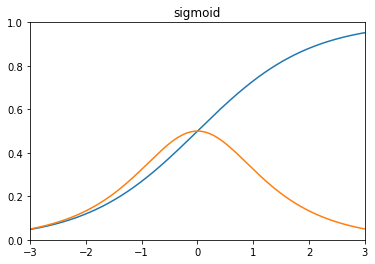

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def sigmoid(x, derivative = False):
    if (derivative == True):
        return np.exp(-x)/(np.exp(-x)**2+1)
    return 1/(1+np.e**(-x))

plt.xlim(-3,3)
plt.ylim(-0,1)
x_range = (np.arange(-3,3,0.01))
plt.plot(np.arange(-3,3,0.01), np.array([sigmoid(x) for x in x_range]))
plt.plot(np.arange(-3,3,0.01), np.array([sigmoid(x, True) for x in x_range]))
plt.title('sigmoid')
plt.show()  

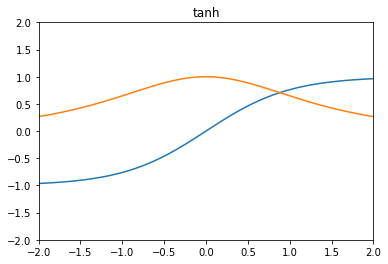

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def tanh(x, derivative = False):
    if (derivative == True):
        return 2/(np.exp(-x)+np.exp(x))
    return np.tanh(x)

plt.xlim(-2,2)
plt.ylim(-2,2)
x_range = (np.arange(-2,2,0.01))
plt.plot(np.arange(-2,2,0.01), np.array([tanh(x) for x in x_range]))
plt.plot(np.arange(-2,2,0.01), np.array([tanh(x, True) for x in x_range]))
plt.title('tanh')
plt.show()  

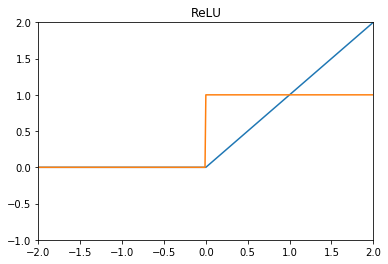

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def ReLU(x):
    if x >= 0:
        return x
    else:
        return 0

def dReLU(x):
    if x >= 0:
        return 1
    else: return 0

plt.xlim(-2,2)
plt.ylim(-1,2)
x_range = (np.arange(-2,2,0.01))
plt.plot(np.arange(-2,2,0.01), np.array([ReLU(x) for x in x_range]))
plt.plot(np.arange(-2,2,0.01), np.array([dReLU(x) for x in x_range]))
plt.title('ReLU')
plt.show()  

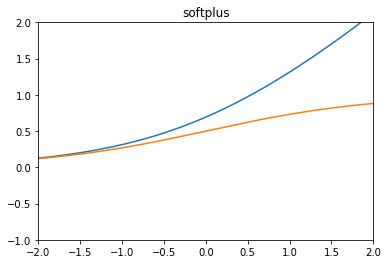

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def softplus(x):
    return np.log(1+np.exp(x))

def dsoftplus(x):
    return np.exp(x)/(1+np.exp(x))

plt.xlim(-2,2)
plt.ylim(-1,2)
x_range = (np.arange(-2,2,0.01))
plt.plot(np.arange(-2,2,0.01), np.array([softplus(x) for x in x_range]))
plt.plot(np.arange(-2,2,0.01), np.array([dsoftplus(x) for x in x_range]))
plt.title('softplus')
plt.show()  